In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

from pandas import read_csv

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
data = read_csv('data/agg/BTC_agg_OI_FR.csv', parse_dates=['timestamp'])
data

,timestamp,Agg Weighted FR,Agg OI
0,2020-04-01,-0.039073,6.966046e+08
1,2020-04-02,0.006521,6.665020e+08
2,2020-04-03,-0.021530,6.837366e+08
3,2020-04-04,-0.008062,6.865173e+08
4,2020-04-05,0.001697,6.757367e+08
...,...,...,...
1365,2023-12-27,0.029520,3.147515e+09
1366,2023-12-28,0.030703,3.135693e+09
1367,2023-12-29,0.019693,3.065951e+09
1368,2023-12-30,0.025019,3.101645e+09


In [3]:
import numpy as np

oi_monthly = data.copy()

oi_monthly = oi_monthly.set_index('timestamp').resample('M').last()
oi_monthly['OI Growth Rate'] = oi_monthly['Agg OI'].pct_change()

oi_monthly = oi_monthly.replace([np.inf, -np.inf], np.nan).dropna()
oi_monthly_average = oi_monthly['OI Growth Rate'].mean()

In [16]:
oi_monthly['OI Growth Rate']

timestamp
2020-05-31    0.424053
2020-06-30    0.134894
2020-07-31    0.289638
2020-08-31   -0.023743
2020-09-30   -0.193850
2020-10-31    0.117945
2020-11-30    0.251350
2020-12-31    0.317859
2021-01-31    0.022646
2021-02-28    0.493545
2021-03-31    0.602913
2021-04-30   -0.181509
2021-05-31   -0.494377
2021-06-30   -0.031560
2021-07-31    0.098864
2021-08-31    0.351007
2021-09-30   -0.218864
2021-10-31    0.496004
2021-11-30   -0.111798
2021-12-31   -0.323421
2022-01-31   -0.256489
2022-02-28    0.051695
2022-03-31    0.200292
2022-04-30   -0.066784
2022-05-31   -0.036967
2022-06-30   -0.248387
2022-07-31    0.085389
2022-08-31   -0.013318
2022-09-30   -0.005796
2022-10-31    0.181397
2022-11-30   -0.174297
2022-12-31    0.031828
2023-01-31    0.053328
2023-02-28   -0.013403
2023-03-31   -0.142329
2023-04-30   -0.001400
2023-05-31    0.025749
2023-06-30    0.301767
2023-07-31   -0.083298
2023-08-31    0.063044
2023-09-30    0.089905
2023-10-31    0.258266
2023-11-30   -0.025545
2

In [17]:
oi_monthly_average

0.056767607917621116

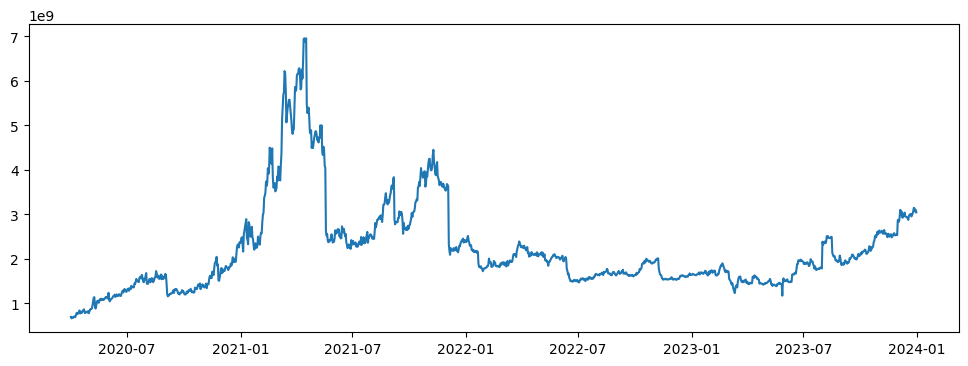

In [4]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

plt.plot(data.timestamp, data['Agg OI'])
plt.show()

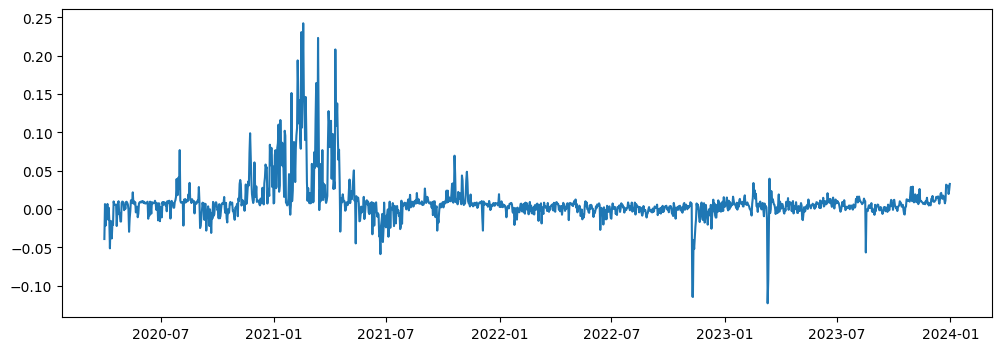

In [5]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

plt.plot(data.timestamp, data['Agg Weighted FR'])
plt.show()

In [6]:
def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    print('Stationary') if (result[1] <= 0.05) & (result[4]['5%'] > result[0]) else print('Non-stationary')

In [7]:
check_stationarity(data['Agg Weighted FR'])

ADF Statistic: -3.114494
p-value: 0.025499
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Stationary


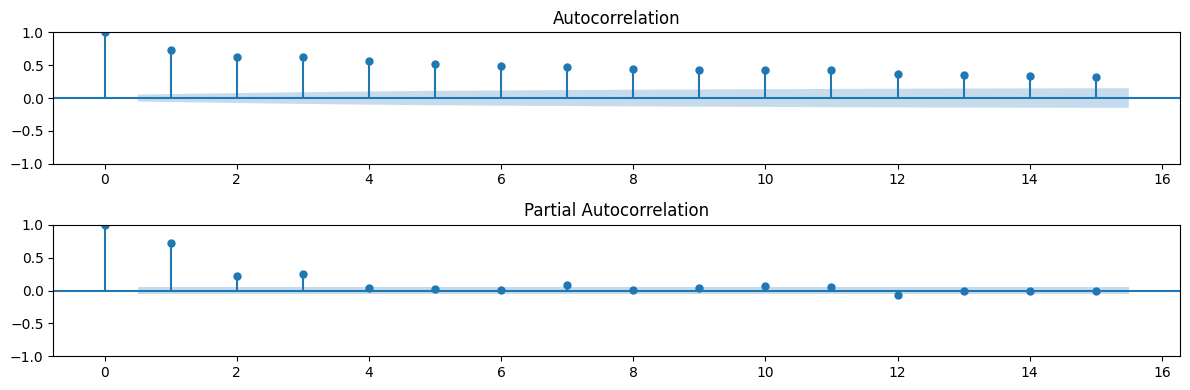

In [8]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 4))

plot_acf(data['Agg Weighted FR'], lags=15, ax=ax[0])
plot_pacf(data['Agg Weighted FR'], lags=15, ax=ax[1], method='ols')

plt.tight_layout()
plt.show()

In [9]:
num_samples = len(data)
train_len = int(0.8* num_samples)

                            AutoReg Model Results                             
Dep. Variable:        Agg Weighted FR   No. Observations:                 1096
Model:                     AutoReg(2)   Log Likelihood                2715.868
Method:               Conditional MLE   S.D. of innovations              0.020
Date:                Sun, 03 Mar 2024   AIC                          -5423.736
Time:                        17:20:14   BIC                          -5403.745
Sample:                             2   HQIC                         -5416.171
                                 1096                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0021      0.001      3.285      0.001       0.001       0.003
Agg Weighted FR.L1     0.5742      0.029     19.468      0.000       0.516       0.632
Agg Weighted FR.L2  

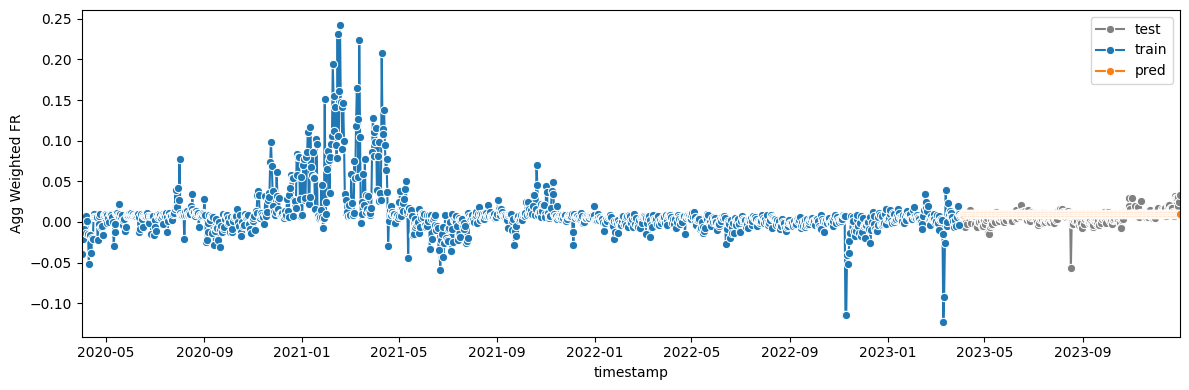

In [10]:
train = data['Agg Weighted FR'][:train_len]
ar_model = AutoReg(train, lags=2).fit()

print(ar_model.summary())
pred = ar_model.predict(start=train_len, end=num_samples, dynamic=False)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
sns.lineplot(x=data.timestamp[train_len:num_samples], y=data['Agg Weighted FR'][train_len:num_samples], marker='o', label='test', color='grey')
sns.lineplot(x=data.timestamp[:train_len], y=train, marker='o', label='train')
sns.lineplot(x=data.timestamp[train_len:num_samples], y=pred, marker='o', label='pred')
ax.set_xlim([data.timestamp.iloc[0], data.timestamp.iloc[-1]])
plt.tight_layout()
plt.show()

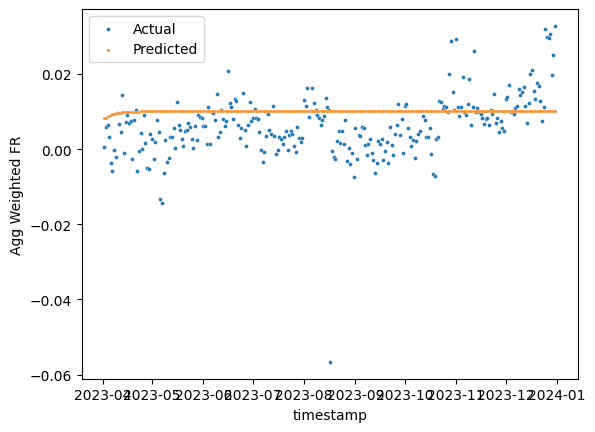

In [11]:
sns.scatterplot(x=data.timestamp[train_len:num_samples], y=data['Agg Weighted FR'][train_len:num_samples], label='Actual', s=8)
sns.scatterplot(x=data.timestamp[train_len:num_samples], y=pred[:-1], label='Predicted', s=5)

plt.legend()
plt.show()

In [12]:
pred.values[pred.values < 0]

array([], dtype=float64)

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = data['timestamp'][:train_len].apply(lambda x: x.timestamp()).values.reshape(-1, 1)
X_test = data['timestamp'][train_len:num_samples].apply(lambda x: x.timestamp()).values.reshape(-1, 1)

y_train = train

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

reg = LinearRegression().fit(X_train_scaled, y_train)

predictions = reg.predict(X_test_scaled)

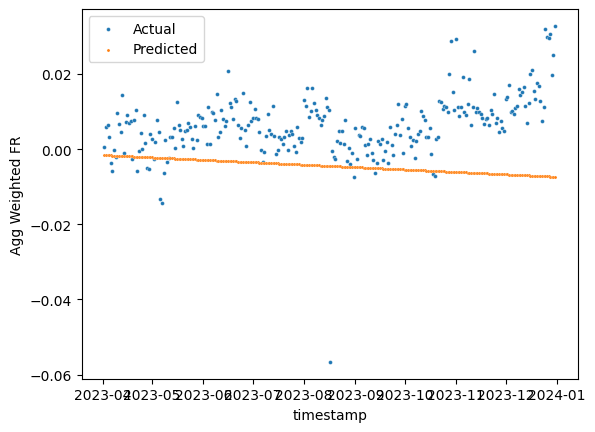

In [14]:
sns.scatterplot(x=data.timestamp[train_len:num_samples], y=data['Agg Weighted FR'][train_len:num_samples], label='Actual', s=8)
sns.scatterplot(x=data.timestamp[train_len:num_samples], y=predictions.flatten(), label='Predicted', s=5)

plt.legend()
plt.show()